In [284]:
import numpy as np
import pandas as pd
import string
from tqdm import tqdm
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import tokelib as tk

In [297]:
with open('/workspaces/nlp/practicas/etc/corpus_1.txt', encoding='utf-8') as f:
    tokens = tk.tokenize(f.read(), parser=' ')
    print(tokens)
    text = tk.remove_stopwords(tokens)

text = [w for w in text]

text

['la', 'ciencia', 'de', 'datos', 'ha', 'emergido', 'como', 'la', 'disciplina', 'clave', 'para', 'la', 'innovación', 'tecnológica', 'en', 'la', 'actualidad', 'gracias', 'a', 'la', 'ciencia', 'de', 'datos', 'las', 'empresas', 'ahora', 'pueden', 'aprovechar', 'grandes', 'volúmenes', 'de', 'información', 'procesarla', 'de', 'manera', 'eficiente', 'y', 'extraer', 'patrones', 'significativos', 'que', 'antes', 'eran', 'invisibles', 'en', 'este', 'contexto', 'la', 'inteligencia', 'artificial', 'ia', 'se', 'presenta', 'como', 'una', 'de', 'las', 'herramientas', 'más', 'poderosas', 'para', 'llevar', 'la', 'ciencia', 'de', 'datos', 'a', 'nuevos', 'niveles', 'de', 'sofisticación', 'a', 'través', 'de', 'técnicas', 'como', 'el', 'machine', 'learning', 'y', 'el', 'deep', 'learning', 'los', 'sistemas', 'de', 'inteligencia', 'artificial', 'son', 'capaces', 'de', 'aprender', 'de', 'los', 'datos', 'y', 'hacer', 'predicciones', 'cada', 'vez', 'más', 'precisas', 'la', 'ciencia', 'de', 'datos', 'no', 'se', 

['ciencia',
 'datos',
 'emergido',
 'como',
 'disciplina',
 'clave',
 'innovación',
 'tecnológica',
 'actualidad',
 'gracias',
 'ciencia',
 'datos',
 'empresas',
 'ahora',
 'pueden',
 'aprovechar',
 'grandes',
 'volúmenes',
 'información',
 'procesarla',
 'manera',
 'eficiente',
 'extraer',
 'patrones',
 'significativos',
 'que',
 'antes',
 'eran',
 'invisibles',
 'este',
 'contexto',
 'inteligencia',
 'artificial',
 'ia',
 'se',
 'presenta',
 'como',
 'herramientas',
 'más',
 'poderosas',
 'llevar',
 'ciencia',
 'datos',
 'nuevos',
 'niveles',
 'sofisticación',
 'través',
 'técnicas',
 'como',
 'machine',
 'learning',
 'deep',
 'learning',
 'sistemas',
 'inteligencia',
 'artificial',
 'son',
 'capaces',
 'aprender',
 'datos',
 'hacer',
 'predicciones',
 'cada',
 'vez',
 'más',
 'precisas',
 'ciencia',
 'datos',
 'no',
 'se',
 'limita',
 'solo',
 'minería',
 'datos',
 'sino',
 'que',
 'implica',
 'profunda',
 'comprensión',
 'algoritmos',
 'machine',
 'learning',
 'que',
 'permiten',
 

In [287]:
WINDOW_SIZE = 4
NUM_NEGATIVE_SAMPLES = 4

data = []

#iterate over all words
for idx,center_word in enumerate(text[WINDOW_SIZE-1:-WINDOW_SIZE]):
    
    #iterate over the context words around the center word
    context_words = [context_word for context_word in text[idx:idx+2*WINDOW_SIZE-1] if context_word != center_word]
    for context_word in context_words:
        
        #get words NOT in the current context as negative examples
        data.append([center_word, context_word, 1])
        negative_samples = np.random.choice([w for w in text[WINDOW_SIZE-1:-WINDOW_SIZE] if w != center_word and w not in context_words], NUM_NEGATIVE_SAMPLES)
        
        for negative_samp in negative_samples:
            
            #add a training row
            data.append([center_word, negative_samp, 0])

In [288]:
df = pd.DataFrame(columns=['center_word', 'context_word', 'label'], data=data)
words = np.intersect1d(df.context_word, df.center_word)
df = df[(df.center_word.isin(words)) & (df.context_word.isin(words))].reset_index(drop=True)

df

,center_word,context_word,label
0,como,ciencia,1
1,como,convierte,0
2,como,son,0
3,como,manera,0
4,como,productos,0
...,...,...,...
8256,vertebral,ciencia,0
8257,vertebral,espera,0
8258,vertebral,sofisticados,0
8259,vertebral,se,0


## f

In [289]:
def sigmoid(v, scale=1):
    return 1 / (1 + np.exp(-scale*v))

In [290]:
def update_embeddings(df, main_embeddings, context_embeddings, learning_rate, debug=False):
    
    #get differences between main embeddings and corresponding context embeddings
    main_embeddings_center = main_embeddings.loc[df.center_word].values
    context_embeddings_context = context_embeddings.loc[df.context_word].values
    diffs = context_embeddings_context - main_embeddings_center
    
    #get similarities, scores, and errors between main embeddings and corresponding context embeddings
    dot_prods = np.sum(main_embeddings_center * context_embeddings_context, axis=1)
    scores = sigmoid(dot_prods)
    errors = (df.label - scores).values.reshape(-1,1)
    
    #calculate updates
    updates = diffs*errors*learning_rate
    updates_df = pd.DataFrame(data=updates)
    updates_df['center_word'] = df.center_word
    updates_df['context_word'] = df.context_word
    updates_df_center = updates_df.groupby('center_word').sum()
    updates_df_context = updates_df.groupby('context_word').sum()
    
    if debug:
        plot_words(debug)
    
    #apply updates
    main_embeddings += updates_df_center.loc[main_embeddings.index]
    context_embeddings -= updates_df_context.loc[context_embeddings.index]
    
    #normalize embeddings
    main_embeddings = normalize_data(main_embeddings)
    context_embeddings = normalize_data(context_embeddings)
    
    #return the updated embeddings
    return main_embeddings, context_embeddings

In [291]:
def normalize_data(data):
    row_norms = np.sqrt((data.values**2).sum(axis=1)).reshape(-1,1)
    return data.divide(row_norms, axis='index')

In [292]:
def plot_words(debug):
    plt.figure(figsize=(8,4))
    
    plt.subplot(1,2,1)
    lim_main_first = main_embeddings.loc[[debug[0]]]
    lim_main_second = main_embeddings.loc[[debug[1]]]
    p1 = plt.scatter(lim_main_first[0], lim_main_first[1], color='r')
    plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_main_first.iterrows():
        plt.text(row[0], row[1], str(idx))
    p2 = plt.scatter(lim_main_second[0], lim_main_second[1], color='r')
    plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_main_second.iterrows():
        plt.text(row[0], row[1], str(idx))
    sim = 1 - cosine(main_embeddings.loc[debug[0]], main_embeddings.loc[debug[1]])
    plt.title('Sim = %s'%round(sim,4), fontsize=20)
    plt.axvline(0, color='k', linestyle='--', alpha=0.5)
    plt.axhline(0, color='k', linestyle='--', alpha=0.5)
    
    t = np.arange(0, 3.14*2+0.1, 0.1)
    plt.plot(np.cos(t), np.sin(t), linewidth=1, color='k', alpha=0.5, linestyle='--')
    
    ###################################
    
    plt.subplot(1,2,2)
    lim_main = main_embeddings.loc[[debug[0]]]
    lim_context = context_embeddings.loc[[debug[1]]]
    p1 = plt.scatter(lim_main[0], lim_main[1], color='r')
    plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_main.iterrows():
        plt.text(row[0], row[1], str(idx))
    p2 = plt.scatter(lim_context[0], lim_context[1], color='b')
    plt.arrow(0,0,float(lim_context[0]), float(lim_context[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_context.iterrows():
        plt.text(row[0], row[1], str(idx))
    sim = 1 - cosine(main_embeddings.loc[debug[0]], context_embeddings.loc[debug[1]])
    plt.title('Sim = %s'%round(sim,4), fontsize=20)
    plt.axvline(0, color='k', linestyle='--', alpha=0.5)
    plt.axhline(0, color='k', linestyle='--', alpha=0.5)
    
    plt.plot(np.cos(t), np.sin(t), linewidth=1, color='k', alpha=0.5, linestyle='--')
    
    plt.show()

/tmp/ipykernel_83631/527702025.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeErr

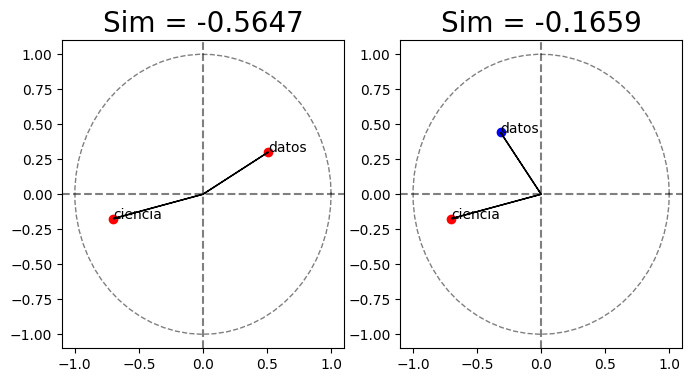

/tmp/ipykernel_83631/527702025.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeErr

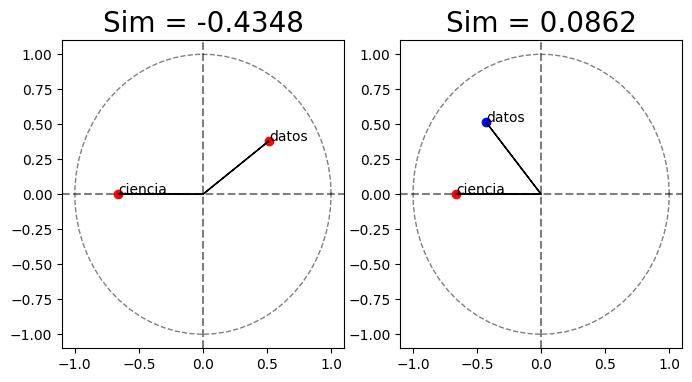

/tmp/ipykernel_83631/527702025.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeErr

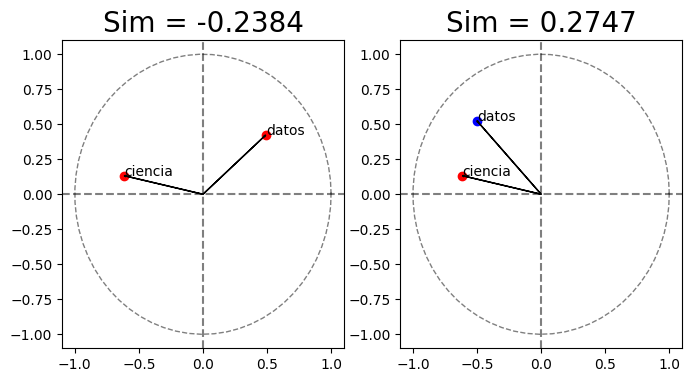

/tmp/ipykernel_83631/527702025.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeErr

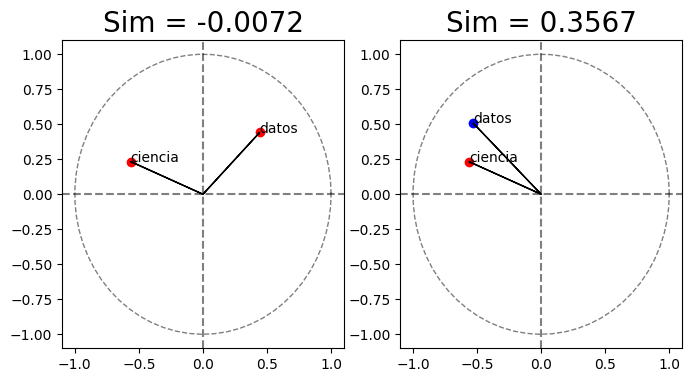

/tmp/ipykernel_83631/527702025.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeErr

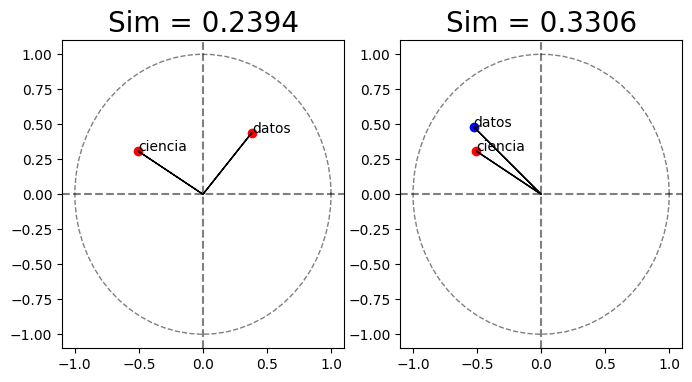

/tmp/ipykernel_83631/527702025.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeErr

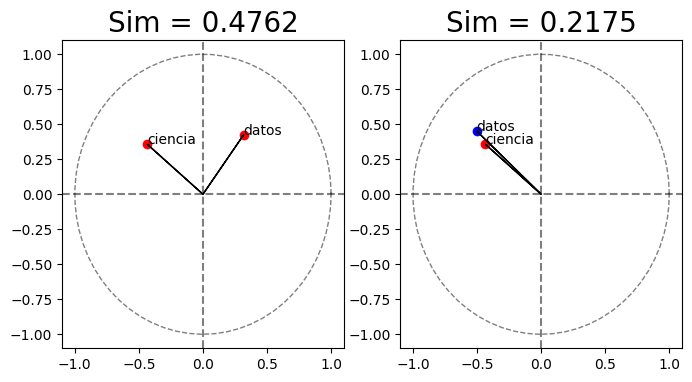

/tmp/ipykernel_83631/527702025.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeErr

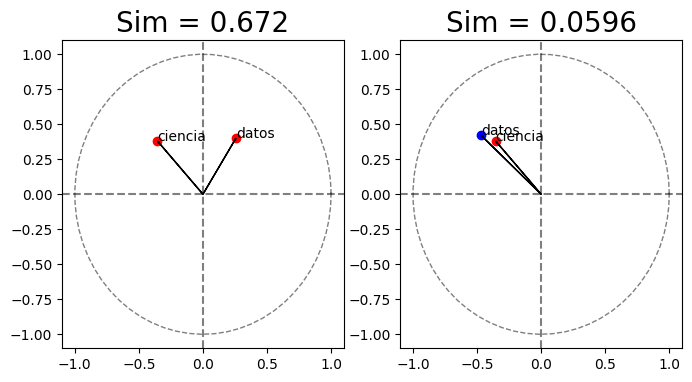

/tmp/ipykernel_83631/527702025.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeErr

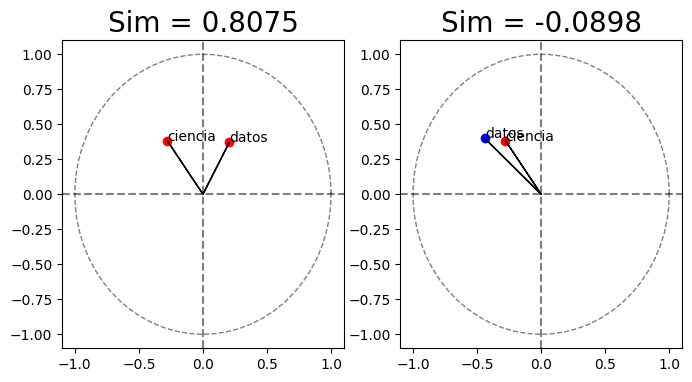

/tmp/ipykernel_83631/527702025.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeErr

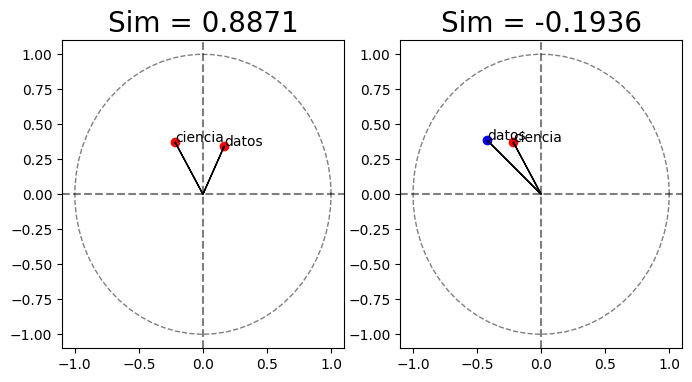

/tmp/ipykernel_83631/527702025.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeErr

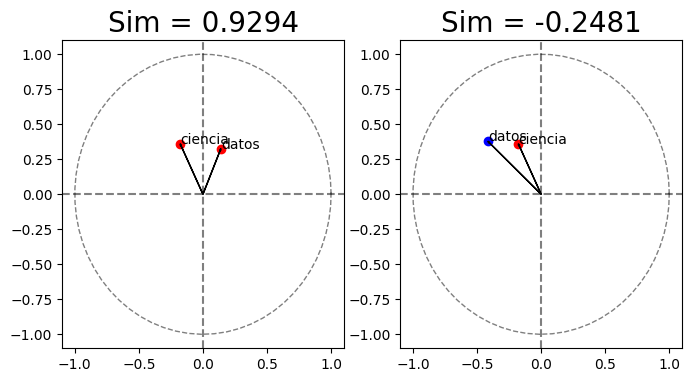

/tmp/ipykernel_83631/527702025.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeErr

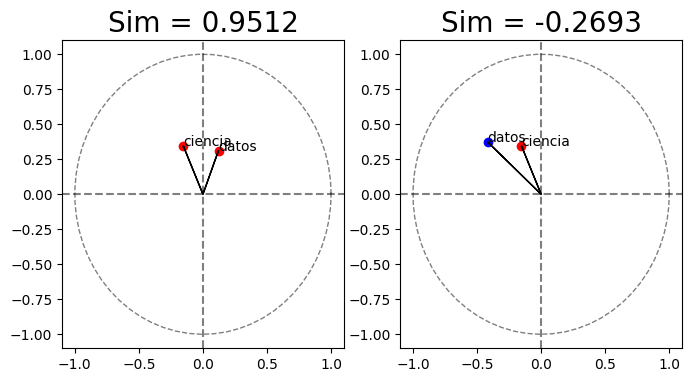

/tmp/ipykernel_83631/527702025.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeErr

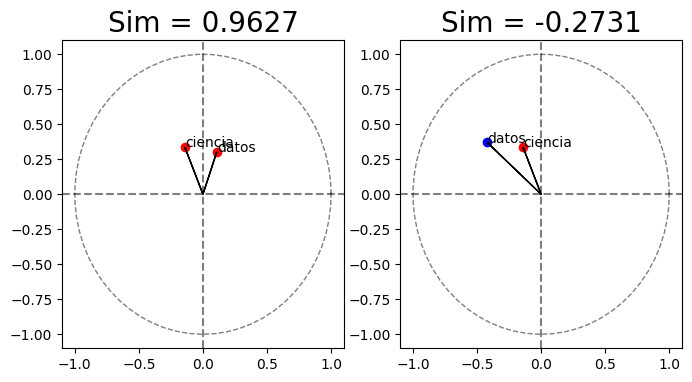

/tmp/ipykernel_83631/527702025.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeErr

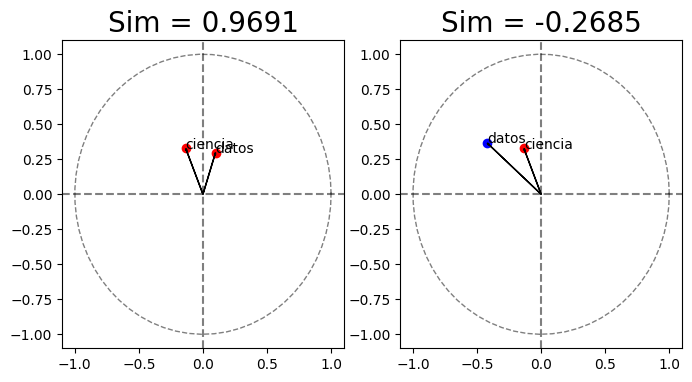

/tmp/ipykernel_83631/527702025.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeErr

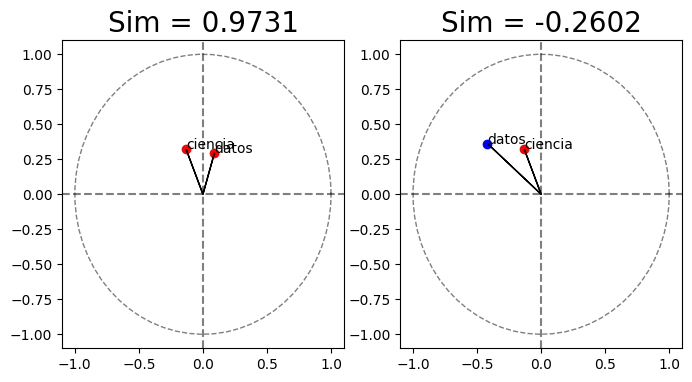

/tmp/ipykernel_83631/527702025.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeErr

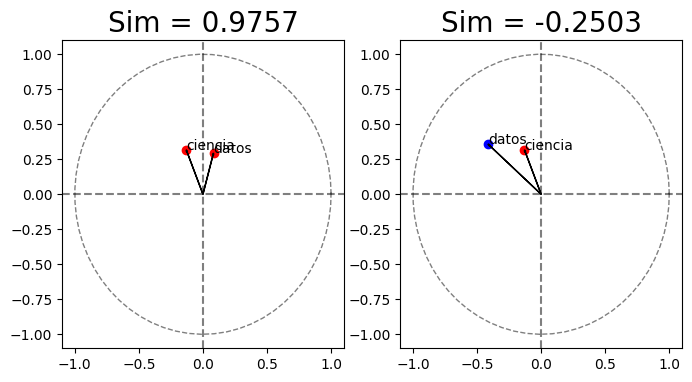

/tmp/ipykernel_83631/527702025.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeErr

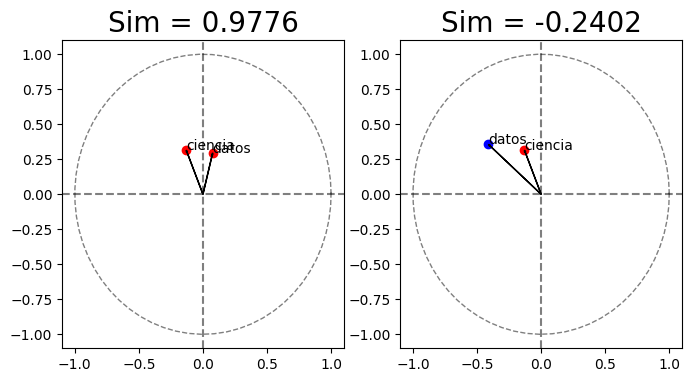

/tmp/ipykernel_83631/527702025.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeErr

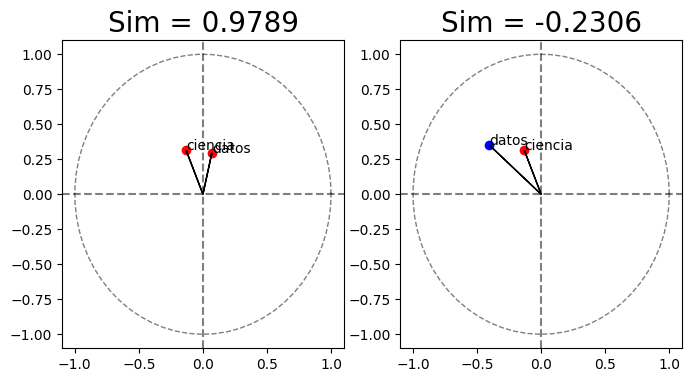

/tmp/ipykernel_83631/527702025.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeErr

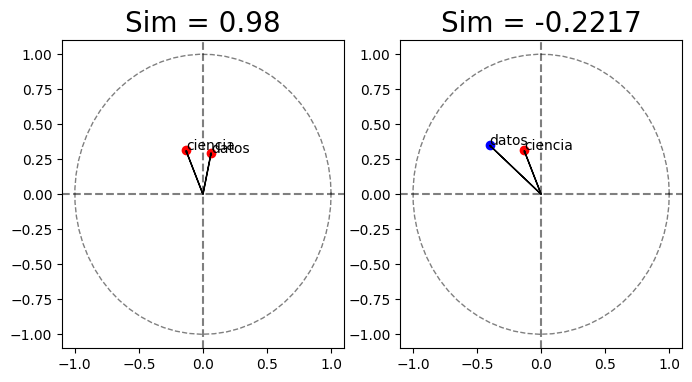

/tmp/ipykernel_83631/527702025.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeErr

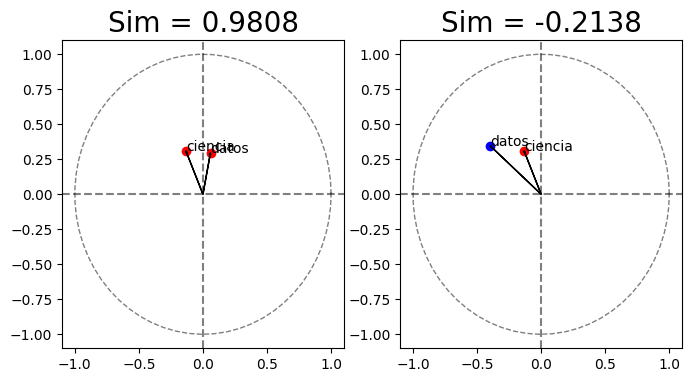

/tmp/ipykernel_83631/527702025.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeErr

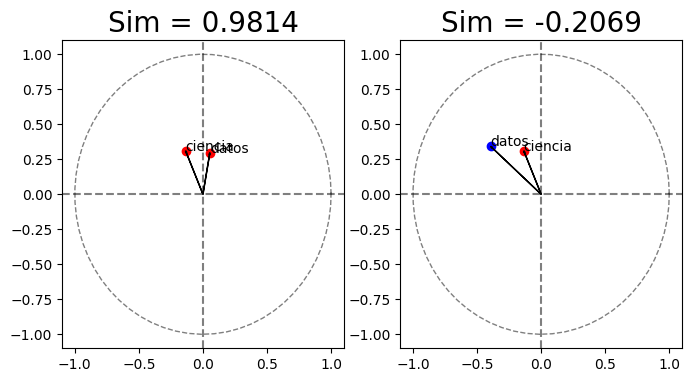

/tmp/ipykernel_83631/527702025.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeErr

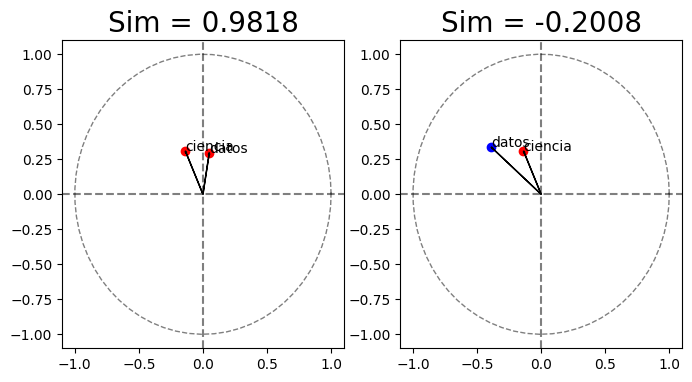

/tmp/ipykernel_83631/527702025.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeErr

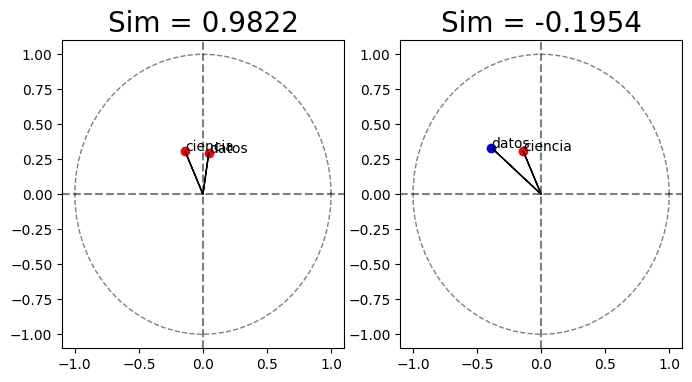

/tmp/ipykernel_83631/527702025.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeErr

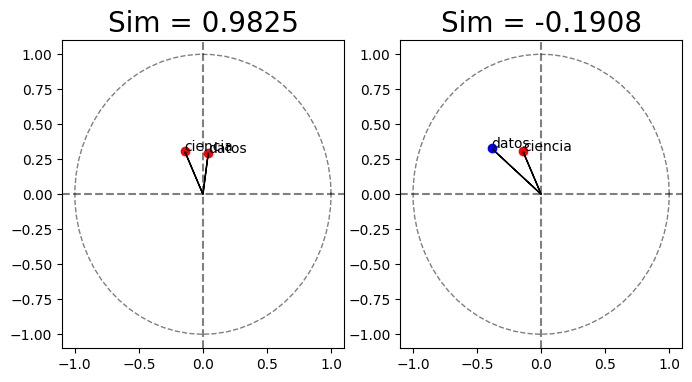

/tmp/ipykernel_83631/527702025.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeErr

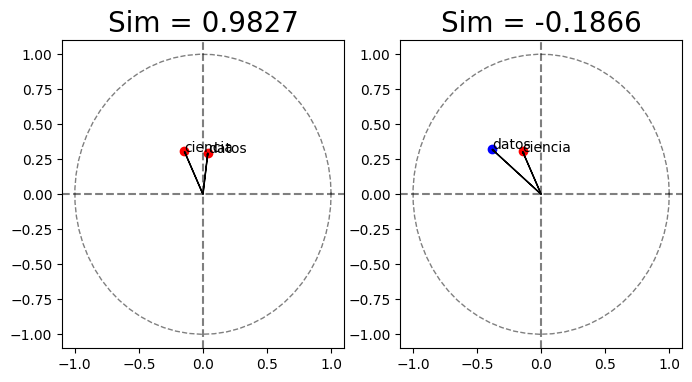

/tmp/ipykernel_83631/527702025.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipykernel_83631/527702025.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeErr

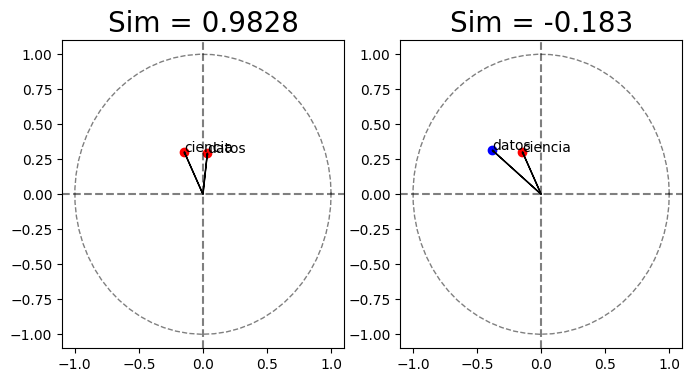

In [293]:
EMBEDDING_SIZE = 5

main_embeddings = np.random.normal(0,0.1,(len(words), EMBEDDING_SIZE))
row_norms = np.sqrt((main_embeddings**2).sum(axis=1)).reshape(-1,1)
main_embeddings = main_embeddings / row_norms

context_embeddings = np.random.normal(0,0.1,(len(words), EMBEDDING_SIZE))
row_norms = np.sqrt((context_embeddings**2).sum(axis=1)).reshape(-1,1)
context_embeddings = context_embeddings / row_norms

main_embeddings = pd.DataFrame(data=main_embeddings, index=words)
context_embeddings = pd.DataFrame(data=context_embeddings, index=words)

for _ in range(25):
    main_embeddings, context_embeddings = update_embeddings(df, main_embeddings, context_embeddings, 0.1, ['ciencia', 'datos'])

In [272]:
L = []
for w1 in words:
    for w2 in words:
        if w1 != w2:
            sim = 1 - cosine(main_embeddings.loc[w1], main_embeddings.loc[w2])
            L.append((w1,w2,sim))
sorted([item for item in L if item[0] == 'ciencia'], key=lambda t: -t[2])[:10]

[('ciencia', 'hacer', np.float64(0.973883545909631)),
 ('ciencia', 'reciben', np.float64(0.887636097515016)),
 ('ciencia', 'comprensión', np.float64(0.8716571560995512)),
 ('ciencia', 'aprender', np.float64(0.8207336100088419)),
 ('ciencia', 'cómo', np.float64(0.8032720718808197)),
 ('ciencia', 'espera', np.float64(0.8015484518288841)),
 ('ciencia', np.str_('real'), np.float64(0.7195041468515244)),
 ('ciencia', np.str_('emergido'), np.float64(0.7171711479182272)),
 ('ciencia', 'niveles', np.float64(0.710130702649171)),
 ('ciencia', 'lo', np.float64(0.7100868820015426))]

In [273]:
from sklearn.decomposition import PCA


In [274]:
pca = PCA(n_components=2)
transf_embeddings = pca.fit_transform(main_embeddings.values)
words_used = main_embeddings.index

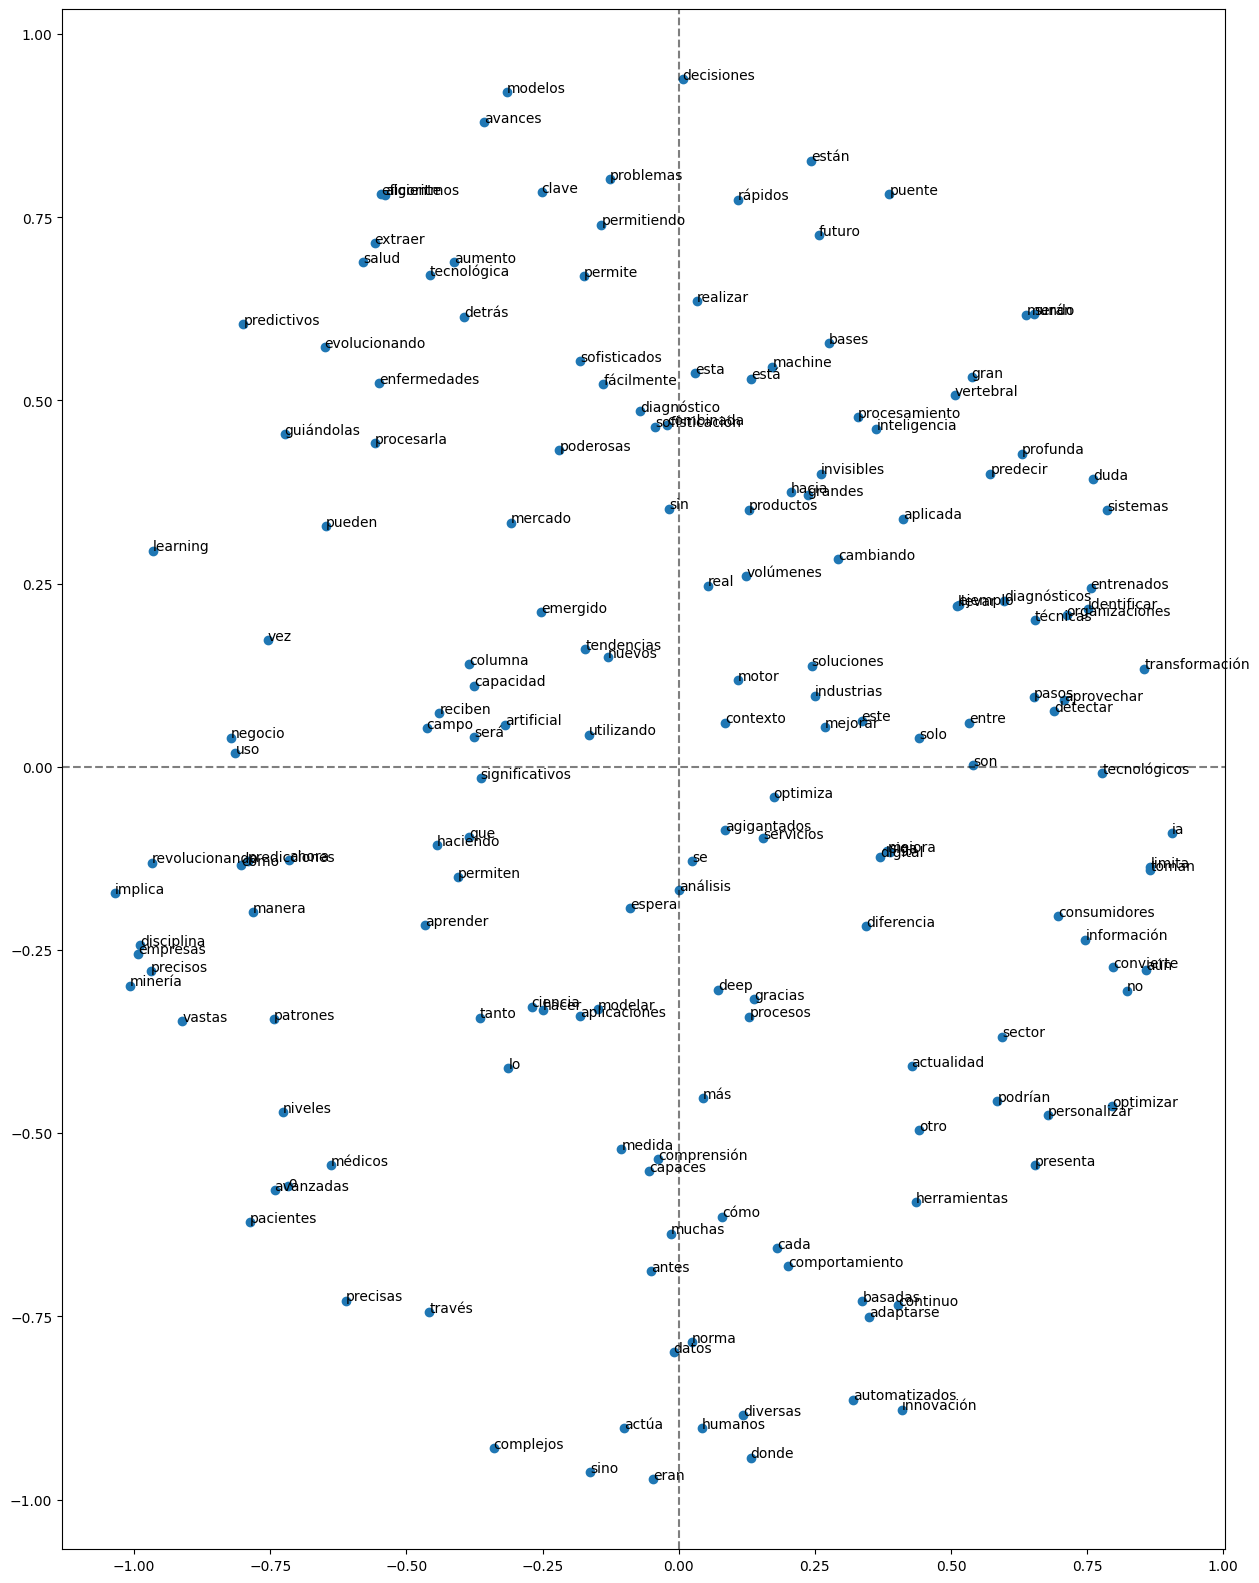

In [275]:
plt.figure(figsize=(15,20))
plt.scatter(transf_embeddings[:,0], transf_embeddings[:,1])
for idx,row in enumerate(transf_embeddings):
    plt.text(row[0], row[1], str(words_used[idx]))
plt.axvline(0, color='k', linestyle='--', alpha=0.5)
plt.axhline(0, color='k', linestyle='--', alpha=0.5)

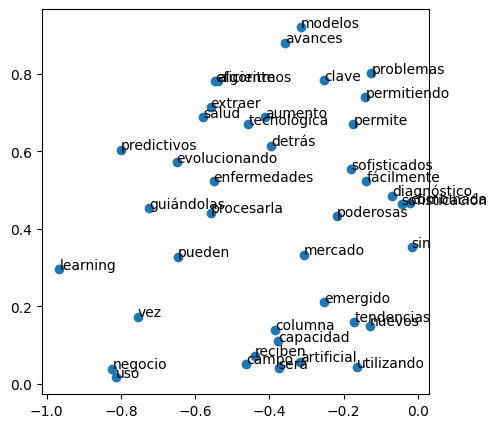

In [276]:

plt.figure(figsize=(5,5))

chosen_idxs = (transf_embeddings[:,0] <= 0) & (transf_embeddings[:,1] > 0)
transf_embeddings = transf_embeddings[chosen_idxs]
words_used = words_used[chosen_idxs]

plt.scatter(transf_embeddings[:,0], transf_embeddings[:,1])
for idx,row in enumerate(transf_embeddings):
    plt.text(row[0], row[1], str(words_used[idx]))